Target: 
        Introduce data augmentation to achieve test accuracy at ot above 99.4%

Result:
        Parameters: 7822
        train accuracy: 98.57%
        test accuracy: 99.08%

Analysis:
        With limited parameters, network is stable and learning to fullest.
        Room to increase network capacity (get parameters to 8000).
        Improve  test accuracy to 99.3%.



In [1]:
# Import Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [2]:
# Data Transformations
train_transforms = transforms.Compose([transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       #transforms.RandomAffine(degrees=(-7.0, 7.0), translate=(0.1,0.1), scale=(0.9, 1.1), fill=(1,)),
                                       #transforms.ColorJitter(brightness=0.1, contrast=0.1),
                                       #transforms.RandomAdjustSharpness(1.1),
                                       #transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])
test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
                                      ])

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
SEED = 99

cuda = torch.cuda.is_available()

torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

#data loader arguments - something you will fetch these from cmdt prompt
train_dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

test_dataloader_args = dict(shuffle=False, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=False, batch_size=64)

train_dataloader = torch.utils.data.DataLoader(train, **train_dataloader_args)
test_dataloader = torch.utils.data.DataLoader(test, **test_dataloader_args)

In [5]:
torch.cuda.is_available()

False

In [ ]:
# Statistics
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('Train Data Stats:')
print('- Numpy Shape ', train.train_data.cpu().numpy().shape)
print('- Tensor shape ', train.train_data.size())
print('- Min ', torch.min(train_data))
print('- Max ', torch.max(train_data))
print('- mean ', torch.mean(train_data))
print('- Std ', torch.std(train_data))
print('- var ', torch.var(train_data))

TypeError: ignored

torch.Size([64, 1, 28, 28])
torch.Size([64])


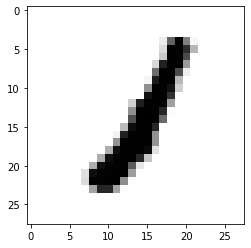

In [6]:
# Print some images
diter = iter(train_dataloader)
images, labels = diter.next()

print(images.shape)
print(labels.shape)

%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

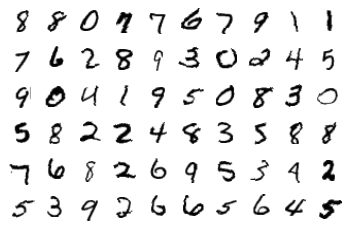

In [7]:
figure = plt.figure()
num_images = 60
for index in range(1, num_images+1):
  plt.subplot(6, 10, index)
  plt.axis('off')
  plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Model

In [8]:
dropout_value = 0.10

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    #Input Block
    self.convblock1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=14, kernel_size=(3,3), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(14),
        nn.Dropout(dropout_value)
    )#output_size=26
    self.convblock2 = nn.Sequential(
        nn.Conv2d(in_channels=14, out_channels=14, kernel_size=(3,3), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(14),
        nn.Dropout(dropout_value)
    )#output_size=24

    self.convblock3 = nn.Sequential(
        nn.Conv2d(in_channels=14, out_channels=10, kernel_size=(3,3), padding=0, bias=False),
        #nn.ReLU()
    )#output_size=22

    self.pool1 = nn.MaxPool2d(2,2)#output_size=11


    self.convblock4 = nn.Sequential(
        nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(1,1), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(12),
        nn.Dropout(dropout_value)
    )#output_size=11

    self.convblock5 = nn.Sequential(
        nn.Conv2d(in_channels=12, out_channels=14, kernel_size=(3,3), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(14),
        nn.Dropout(dropout_value)
    )#output_size=9

    self.convblock6 = nn.Sequential(
        nn.Conv2d(in_channels=14, out_channels=12, kernel_size=(3,3), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(12),
        nn.Dropout(dropout_value)
    )#output_size=7

    self.convblock7 = nn.Sequential(
        nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3,3), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(12),
        nn.Dropout(dropout_value)
    )#output_size=5

    #output block
    self.gap = nn.Sequential(
        nn.AvgPool2d(kernel_size=5)
    )#output_size=1

    self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
    )#output_size=7


  def forward(self, x):
    x = self.convblock1(x)
    x = self.convblock2(x)
    x = self.convblock3(x)
    x = self.pool1(x)
    x = self.convblock4(x)
    x = self.convblock5(x)
    x = self.convblock6(x)
    x = self.convblock7(x)
    x = self.gap(x)
    x = self.convblock8(x)

    x = x.view(-1, 10)

    return F.log_softmax(x, dim=1)

In [9]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 14, 26, 26]             126
              ReLU-2           [-1, 14, 26, 26]               0
       BatchNorm2d-3           [-1, 14, 26, 26]              28
           Dropout-4           [-1, 14, 26, 26]               0
            Conv2d-5           [-1, 14, 24, 24]           1,764
              ReLU-6           [-1, 14, 24, 24]               0
       BatchNorm2d-7           [-1, 14, 24, 24]              28
           Dropout-8           [-1, 14, 24, 24]               0
            Conv2d-9           [-1, 10, 22, 22]           1,260
        MaxPool2d-10           [-1, 10, 11, 11]               0
           Conv2d-11           [-1, 12, 11, 11]             120
             ReLU-12           [-1, 12, 11, 11]               0
      BatchNorm2d-13           [-1, 12, 11, 11]              24
          Dropout-14           [-1,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [10]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [11]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=8, gamma=0.05)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_dataloader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_dataloader)

EPOCH: 0


Loss=0.18016327917575836 Batch_id=937 Accuracy=90.07: 100%|██████████| 938/938 [01:30<00:00, 10.33it/s]



Test set: Average loss: 0.0699, Accuracy: 9784/10000 (97.84%)

EPOCH: 1


Loss=0.05140057951211929 Batch_id=937 Accuracy=97.35: 100%|██████████| 938/938 [01:30<00:00, 10.33it/s]



Test set: Average loss: 0.0427, Accuracy: 9877/10000 (98.77%)

EPOCH: 2


Loss=0.19017745554447174 Batch_id=937 Accuracy=97.85: 100%|██████████| 938/938 [01:31<00:00, 10.28it/s]



Test set: Average loss: 0.0301, Accuracy: 9906/10000 (99.06%)

EPOCH: 3


Loss=0.0071549322456121445 Batch_id=937 Accuracy=98.09: 100%|██████████| 938/938 [01:31<00:00, 10.27it/s]



Test set: Average loss: 0.0341, Accuracy: 9885/10000 (98.85%)

EPOCH: 4


Loss=0.06870775669813156 Batch_id=937 Accuracy=98.21: 100%|██████████| 938/938 [01:31<00:00, 10.27it/s]



Test set: Average loss: 0.0298, Accuracy: 9898/10000 (98.98%)

EPOCH: 5


Loss=0.013239657506346703 Batch_id=937 Accuracy=98.30: 100%|██████████| 938/938 [01:31<00:00, 10.27it/s]



Test set: Average loss: 0.0272, Accuracy: 9910/10000 (99.10%)

EPOCH: 6


Loss=0.07893378287553787 Batch_id=937 Accuracy=98.44: 100%|██████████| 938/938 [01:31<00:00, 10.30it/s]



Test set: Average loss: 0.0242, Accuracy: 9910/10000 (99.10%)

EPOCH: 7


Loss=0.016809869557619095 Batch_id=937 Accuracy=98.41: 100%|██████████| 938/938 [01:31<00:00, 10.29it/s]



Test set: Average loss: 0.0290, Accuracy: 9903/10000 (99.03%)

EPOCH: 8


Loss=0.1568092256784439 Batch_id=937 Accuracy=98.69: 100%|██████████| 938/938 [01:31<00:00, 10.27it/s]



Test set: Average loss: 0.0220, Accuracy: 9920/10000 (99.20%)

EPOCH: 9


Loss=0.21127788722515106 Batch_id=937 Accuracy=98.77: 100%|██████████| 938/938 [01:31<00:00, 10.29it/s]



Test set: Average loss: 0.0210, Accuracy: 9925/10000 (99.25%)

EPOCH: 10


Loss=0.02628398686647415 Batch_id=937 Accuracy=98.83: 100%|██████████| 938/938 [01:31<00:00, 10.29it/s]



Test set: Average loss: 0.0207, Accuracy: 9928/10000 (99.28%)

EPOCH: 11


Loss=0.03303416073322296 Batch_id=937 Accuracy=98.80: 100%|██████████| 938/938 [01:31<00:00, 10.28it/s]



Test set: Average loss: 0.0197, Accuracy: 9927/10000 (99.27%)

EPOCH: 12


Loss=0.014333437196910381 Batch_id=937 Accuracy=98.83: 100%|██████████| 938/938 [01:31<00:00, 10.27it/s]



Test set: Average loss: 0.0194, Accuracy: 9930/10000 (99.30%)

EPOCH: 13


Loss=0.007639853283762932 Batch_id=937 Accuracy=98.88: 100%|██████████| 938/938 [01:31<00:00, 10.28it/s]



Test set: Average loss: 0.0195, Accuracy: 9935/10000 (99.35%)

EPOCH: 14


Loss=0.0038994760252535343 Batch_id=937 Accuracy=98.85: 100%|██████████| 938/938 [01:30<00:00, 10.33it/s]



Test set: Average loss: 0.0188, Accuracy: 9935/10000 (99.35%)



Text(0.5, 1.0, 'Test Accuracy')

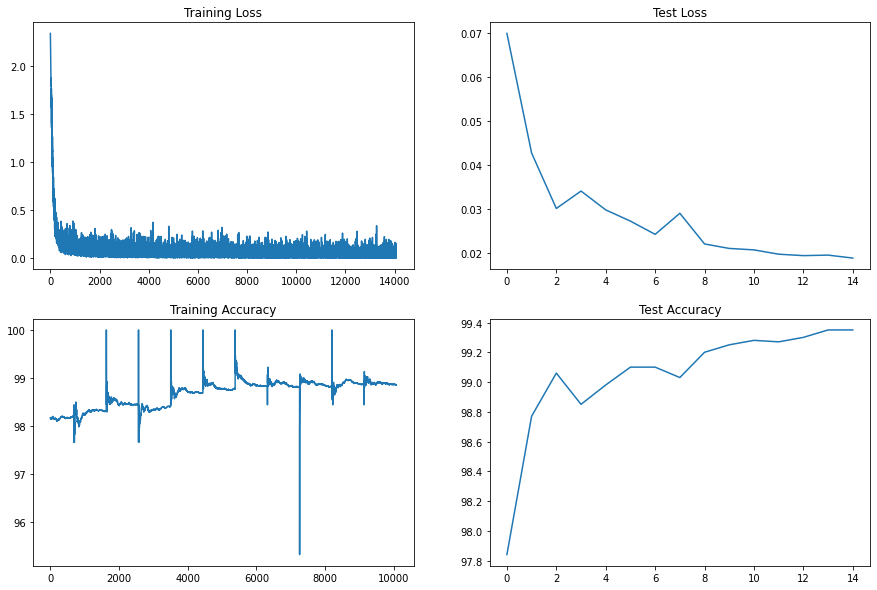

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")